# MNIST Classification

Cilem Notebooku je seznameni s datsetem MNIST a vicevrstvym perceptronem (MLP).

Vasim ukolem je upravit Notebook tak, abyste dosahli co nejlepsi presnosti (accuracy) predikce na testovacim datasetu. Muzete vyzkouset napr. zmenu architektury site (vice vrstev, vice uzlu ve vrstvach, jine aktivacni funkce) nebo zmenu trenovani (zmena velikosti learning rate, velikosti batch_size nebo poctu epoch).

In [ ]:
# import knihoven
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# pro jednoduchost bude v tomto notebooku pouzita knihovna Keras, ktera bezi nad Tensorflow
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.utils import to_categorical, set_random_seed
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau

opt = SGD(learning_rate=0.01)  # Počáteční learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [ ]:
# zaseedovani pro reproducibilitu vypoctu https://keras.io/examples/keras_recipes/reproducibility_recipes/
set_random_seed(42)

MNIST je jeden ze znamych datasetu. Sklada se z obrazku rucne psanych cislic 0 az 9. Nasim ukolem je naucit neuronovou sit, ktera dokaze rozpoznat, jake cislo je na obrazku.

MNIST jde jednoduse [stahnout s pomoci Kerasu](https://keras.io/api/datasets/mnist/). Celkem se jedna o 60000 trenovacich a 10000 testovacich obrazku o rozmerech 28x28.

In [ ]:
from keras.datasets import mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


Vytiskneme si 100 cislic z trenovaci mnoziny

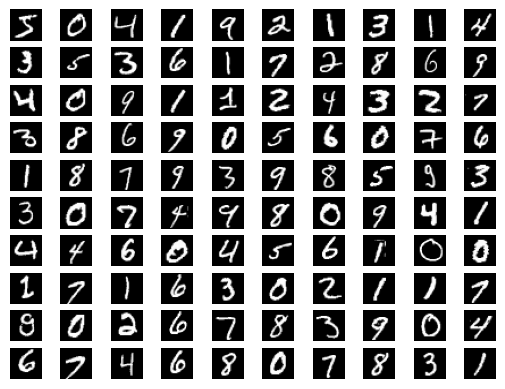

In [ ]:
plt.figure()

for i in range(100):
  plt.subplot(10, 10, i+1)
  plt.imshow(x_train[i], cmap='gray')
  plt.axis('off')
plt.show()

Pro kazdy obrazek zname spravny vystup. Prirazene labely jsou:

In [ ]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Celkem mame 10 trid:

In [ ]:
n_labels = len(np.unique(y_train))
n_labels

10

Labely tedy odpovidaji cislum na obrazcich, tedy se jedna o cisla 0 az 9. Pro klasifikaci vsak potrebujeme trochu jiny vystup. Provedeme tzv. one-hot encoding. Kazdy label bude reprezentovan vektorem delky D, kde D je pocet trid. Tento vektor bude mit vsude same 0 a jen pro spravnou tridu 1.

Napr. 5 bude v nasem pripade reprezentovana jako vektor [0,0,0,0,0,1,0,0,0,0]

In [ ]:
y_train[0]

5

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

MLP ocekava na vstupu vektor. Obrazky cislic maji dva rozmery, a tak je musime prevest do tvaru vektoru.

In [ ]:
x_train[0].shape

(28, 28)

In [ ]:
x_size = x_train[0].shape[0] * x_train[0].shape[1]

x_train = x_train.reshape([-1, x_size])
x_test = x_test.reshape([-1, x_size])

In [ ]:
x_train[0].shape

(784,)

Jednotlive hodnoty vektoru x_train jsou cela cisla v rozmezi 0-255, coz odpovida barve v odstinech sede. Budeme chtit hodnoty normalizovat.

In [ ]:
np.min(x_train), np.max(x_train)

(0, 255)

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255.
x_test /= 255.

In [ ]:
np.min(x_train), np.max(x_train)

(0.0, 1.0)

Jako zaklad pro nas model poslouzi trida `Sequential`, do ktere budeme metodou `add` pridavat jednotlive vrstvy MLP. Vypocet se provadi "shora dolu".

Fully-connected vrstva je zde reprezentovana tridou `Dense`, ktere jako parametr predavame pocet uzlu ve vrstve. Podle [dokumentace](https://keras.io/api/layers/core_layers/dense/) nam trida `Dense` umoznuje pridat i [aktivacni funkci](https://keras.io/api/layers/activations/) pomoci parametru `activation`. Dale pak umoznuje pridat treba i regularizaci - napr:`kernel_regularizer=regularizers.L2(0.01)` (vice k regularizaci najdete [zde](https://keras.io/api/layers/regularizers/)).

Aktivacni funkci muzeme pridat take pomoci tridy `Activation`.

V neposledni rade musime definovat velikost vstupu `input_dim` (pouze v prvni vrstve a ostatni se dopoctou).

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=x_size, activation='relu'))
model.add(Dense(32, activation='relu'))  # Přidání vrstvy s 32 uzly a aktivací ReLU
model.add(Dense(64, activation='relu'))  # Přidání vrstvy s 64 uzly a aktivací ReLU
model.add(Dense(n_labels, activation='softmax'))  # Změna aktivační funkce


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                12560     
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 15866 (61.98 KB)
Trainable params: 15866 (61.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Jak chceme model natrenovat definujeme metodou `compile`. Volime chybovou funkci `categorical_crossentropy`, k uceni modelu pouzijeme `sgd` a behem trenovani/testovani chceme pocitat presnost `accuracy`.

In [ ]:
opt = SGD(learning_rate=0.001)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

Natrenujeme model.

In [ ]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=20, batch_size=5)

Epoch 1/20
9600/9600 [==============================] - 25s 3ms/step - loss: 1.3503 - accuracy: 0.5848 - val_loss: 0.5137 - val_accuracy: 0.8521
Epoch 2/20
9600/9600 [==============================] - 27s 3ms/step - loss: 0.4453 - accuracy: 0.8710 - val_loss: 0.3630 - val_accuracy: 0.8916
Epoch 3/20
9600/9600 [==============================] - 25s 3ms/step - loss: 0.3580 - accuracy: 0.8957 - val_loss: 0.3158 - val_accuracy: 0.9072
Epoch 4/20
9600/9600 [==============================] - 24s 2ms/step - loss: 0.3171 - accuracy: 0.9087 - val_loss: 0.2892 - val_accuracy: 0.9146
Epoch 5/20
9600/9600 [==============================] - 21s 2ms/step - loss: 0.2885 - accuracy: 0.9162 - val_loss: 0.2686 - val_accuracy: 0.9217
Epoch 6/20
9600/9600 [==============================] - 25s 3ms/step - loss: 0.2671 - accuracy: 0.9229 - val_loss: 0.2466 - val_accuracy: 0.9283
Epoch 7/20
9600/9600 [==============================] - 24s 2ms/step - loss: 0.2497 - accuracy: 0.9268 - val_loss: 0.2358 - val_ac

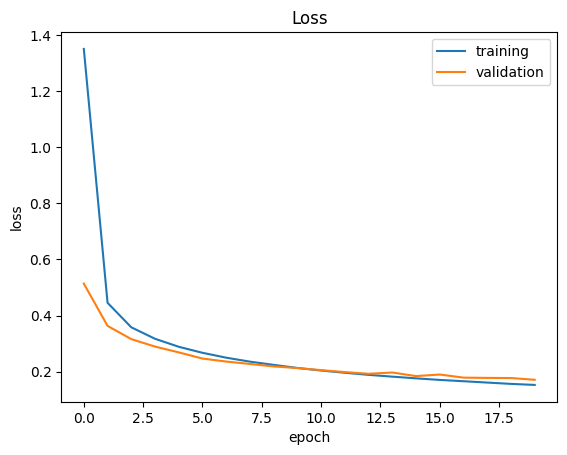

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

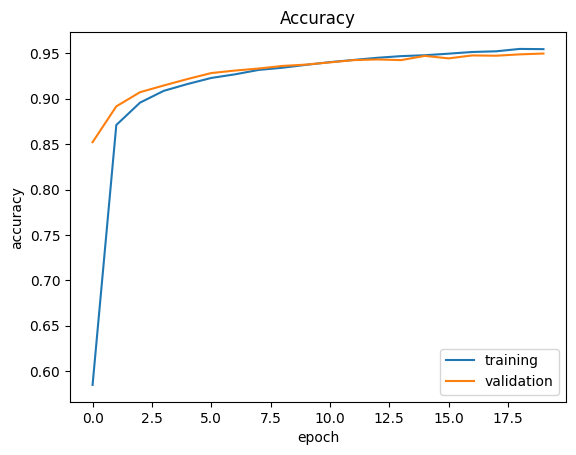

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

Vyhodnotime model na testovacim datatsetu. Chceme dosahnout presnosti minimalne 88.56%

In [ ]:
loss, acc = model.evaluate(x_test, y_test, batch_size=32)
print("Test loss: %.2f" % (loss))
print("Test accuracy: %.2f%%" % (100.0 * acc))

313/313 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.9513
Test loss: 0.16
Test accuracy: 95.13%
